In [1]:
import os
import sys
from pathlib import Path

CWD = [p for p in Path().resolve().parents if p.stem == "eco-nsr"][0]
sys.path.append(CWD.as_posix())
sys.path.append(os.path.join(CWD, "src", "representation", "PyTorch_VAE"))

In [2]:
from copy import deepcopy
from typing import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.cluster import MeanShift
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Resize, ToTensor
from tqdm import tqdm
from yacs.config import CfgNode

from src.data.RavenMatrices import RavenMatrices
from src.data.RavenShapes import RavenShapes
from src.representation.PyTorch_VAE.models import *  # noqa: F403
from src.representation.cluster import cluster

In [3]:
def show_image(img: np.ndarray) -> None:
    """
    Recieve numpy array of shape [channels, height, width] and display it using pyplot
    """
    if len(img.shape) == 3:
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.axis("off")
        plt.show()
    if len(img.shape) == 4:
        for i in range(img.shape[0]):
            plt.subplot(img.shape[0], 1, i + 1)
            plt.imshow(np.transpose(img[i], (1, 2, 0)))
            plt.axis("off")
        plt.show()
    else:
        raise ValueError("Invalid image shape")

def crop_img(img: np.ndarray, bbox: list[float]) -> np.ndarray:
    """
    Use bbox to crop an image to a single panel.

    Parameters
    ----------
    img : np.ndarray
        Panel image of shape [channels, height, width]
    bbox : list[float]
        Shape bounding box
    """
    if len(img.shape) == 3:
        return img[:, int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])]
    if len(img.shape) == 4:
        return img[:, :, int(bbox[1]) : int(bbox[3]), int(bbox[0]) : int(bbox[2])]
    else:
        raise ValueError("Invalid image shape")


def sample_z(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """
    Sample from a Gaussian distribution defined by mu and logvar. Identical to model.reparametrize

    Parameters
    ----------
    mu : torch.Tensor
        Mean of the Gaussian distribution.
    logvar : torch.Tensor
        Log variance of the Gaussian distribution.

    Returns
    -------
    torch.Tensor
        Sampled tensor from the Gaussian distribution.
    """
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

In [4]:
with open(os.path.join(CWD, "global_cfg.yml"), "r") as f:
    global_cfg = CfgNode.load_cfg(f)

In [5]:
model = vae_models[global_cfg.REPRESENTATION.MODEL.name](  # noqa: F405
    hidden_dims=[32] * int(np.log2(global_cfg.REPRESENTATION.TRAINING.patch_size / 4)),
    **global_cfg.REPRESENTATION.MODEL,
)

checkpoint = torch.load(
    os.path.join(
        CWD,
        global_cfg.REPRESENTATION.TRAINING.output,
        global_cfg.REPRESENTATION.MODEL.name,
        "version_1",
        "checkpoints",
        "last.ckpt",
    ),
    weights_only=True,
)

model_state_dict = OrderedDict()
for key in checkpoint["state_dict"].keys():
    if key.startswith("model."):
        model_state_dict[key[6:]] = checkpoint["state_dict"][key]
    else:
        model_state_dict[key] = checkpoint["state_dict"][key]

model.load_state_dict(model_state_dict)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model = model.eval()

In [6]:
matrices = RavenMatrices(
    os.path.join(global_cfg.DATA.path, "RAVEN-F"),
    os.path.join(CWD, global_cfg.DATA.RavenMatrices.dataset_file),
    transform=Compose([
        ToTensor(),
    ]),
)

shapes = RavenShapes(
    os.path.join(global_cfg.DATA.path, "RAVEN-F"),
    os.path.join(CWD, global_cfg.DATA.RavenShapes.dataset_file),
    transform=Compose([
        ToTensor(),
        Resize((
            global_cfg.REPRESENTATION.TRAINING.patch_size,
            global_cfg.REPRESENTATION.TRAINING.patch_size,
        ))
    ])
)

sample_ds, _ = random_split(shapes, [0.05, 0.95])  # used to find dim ranges
sample_loader = DataLoader(
    sample_ds, batch_size=128, shuffle=False, num_workers=16, pin_memory=True, drop_last=False
)

**_Latent Traversals_**

In [7]:
minim = torch.zeros(1, global_cfg.REPRESENTATION.MODEL.latent_dim)
maxim = torch.zeros(1, global_cfg.REPRESENTATION.MODEL.latent_dim)

for img in tqdm(sample_loader):
    img = img.to(device)
    with torch.no_grad():
        mu, logvar = model.encode(img)
        z = sample_z(mu, logvar)
    z = z.cpu()
    minim = torch.min(minim, torch.min(z, dim=0).values)
    maxim = torch.max(maxim, torch.max(z, dim=0).values)

for i in range(global_cfg.REPRESENTATION.MODEL.latent_dim):
    print(f"Dimension {i}: Min = {minim[0, i]}, Max = {maxim[0, i]}")

100%|██████████| 749/749 [00:15<00:00, 49.93it/s]

Dimension 0: Min = -10.710894584655762, Max = 1.0071734189987183
Dimension 1: Min = -5.772705554962158, Max = 6.390678405761719
Dimension 2: Min = -8.909011840820312, Max = 16.537097930908203
Dimension 3: Min = -0.07517946511507034, Max = 12.588480949401855


Latent Dimension 0
Values: [-10.710894584655762, -9.873889923095703, -9.036885261535645, -8.199880599975586, -7.362874984741211, -6.525870323181152, -5.688865661621094, -4.851860523223877, -4.014855861663818, -3.1778512001037598, -2.340846061706543, -1.5038414001464844, -0.6668367385864258, 0.1701679229736328, 1.0071734189987183]


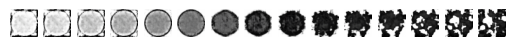

Latent Dimension 1
Values: [-5.772705554962158, -4.903892517089844, -4.035079479217529, -3.1662662029266357, -2.2974531650543213, -1.4286398887634277, -0.5598268508911133, 0.30898618698120117, 1.1777992248535156, 2.04661226272583, 2.9154257774353027, 3.784238338470459, 4.653051853179932, 5.521864414215088, 6.390678405761719]


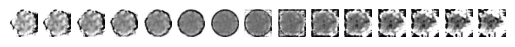

Latent Dimension 2
Values: [-8.909011840820312, -7.091432571411133, -5.273853302001953, -3.4562740325927734, -1.6386947631835938, 0.17888450622558594, 1.9964637756347656, 3.8140430450439453, 5.631622314453125, 7.449201583862305, 9.266780853271484, 11.084360122680664, 12.901939392089844, 14.719518661499023, 16.537097930908203]


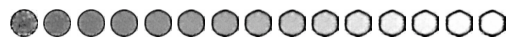

Latent Dimension 3
Values: [-0.07517946511507034, 0.8293676972389221, 1.733914852142334, 2.6384618282318115, 3.543009042739868, 4.447556018829346, 5.352103233337402, 6.256650447845459, 7.161197662353516, 8.06574535369873, 8.970292091369629, 9.874839782714844, 10.779386520385742, 11.683934211730957, 12.588480949401855]


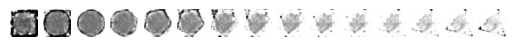

In [8]:
n = 15

sample = matrices[23]
img = crop_img(sample[0]["img"], sample[0]["locs"][0])
img = Resize((
    global_cfg.REPRESENTATION.TRAINING.patch_size,
    global_cfg.REPRESENTATION.TRAINING.patch_size,
))(img)

img = img.to(device)

with torch.no_grad():
    mu, logvar = model.encode(img.unsqueeze(0))
    z = sample_z(mu, logvar).cpu()

for dim in range(global_cfg.REPRESENTATION.MODEL.latent_dim):
    _z = deepcopy(z)
    fig, axs = plt.subplots(1, n)
    print(f"Latent Dimension {dim}")
    
    vals = np.linspace(minim[0, dim], maxim[0, dim], n)
    for idx, val in enumerate(vals):
        _z[0, dim] = val
        _z = _z.to(device)
        with torch.no_grad():
            img = model.decode(_z)
        img = img[0].cpu().permute(1, 2, 0).clip(0, 1)
        axs[idx].imshow(img)
        axs[idx].set_axis_off()
    print(f"Values: {[val.item() for val in vals]}")
    plt.show()

**_Clustering Results_**

Found 4 clusters in dimension 0.


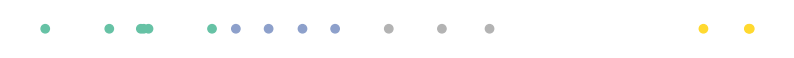

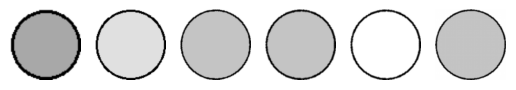

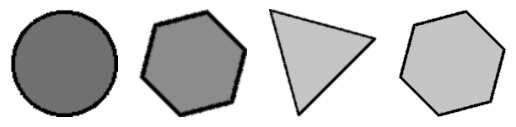

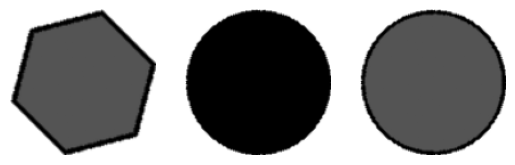

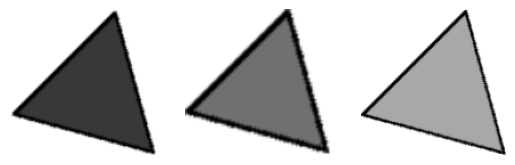

Found 4 clusters in dimension 1.


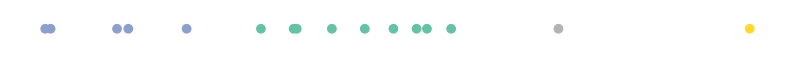

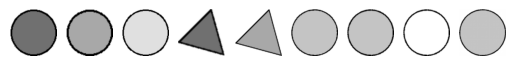

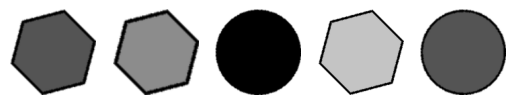

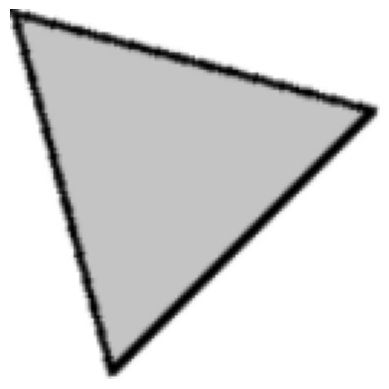

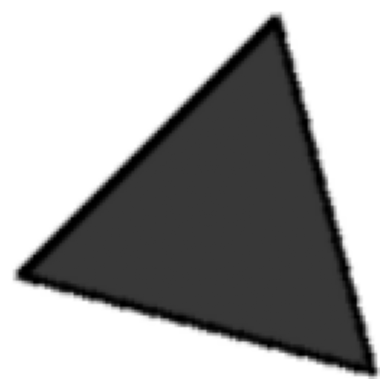

Found 6 clusters in dimension 2.


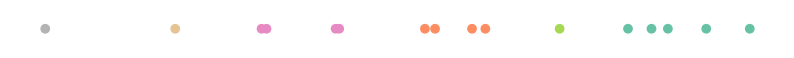

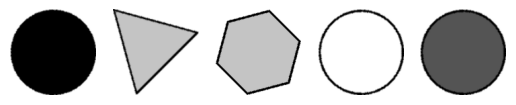

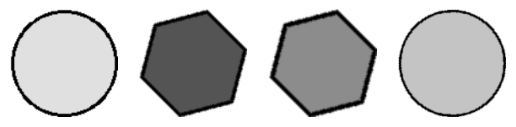

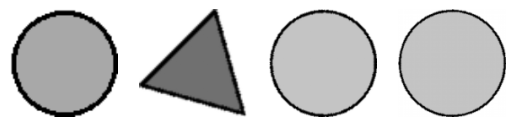

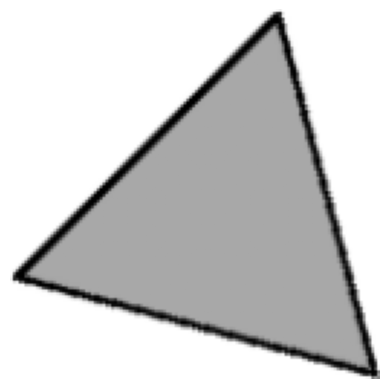

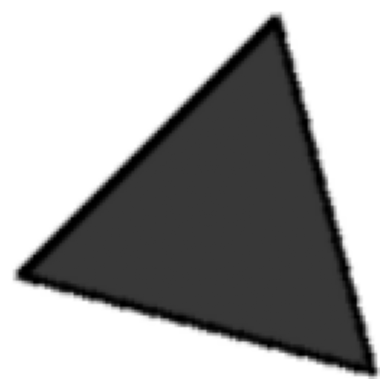

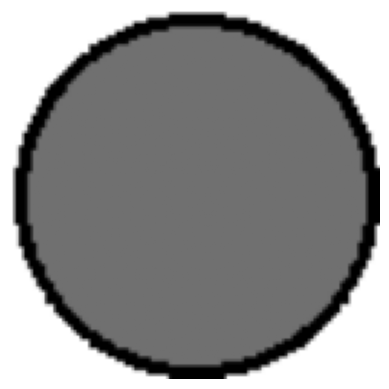

Found 3 clusters in dimension 3.


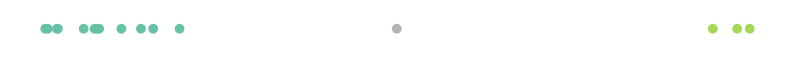

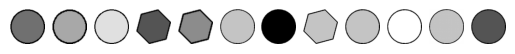

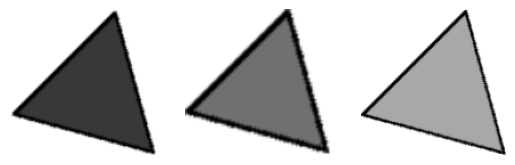

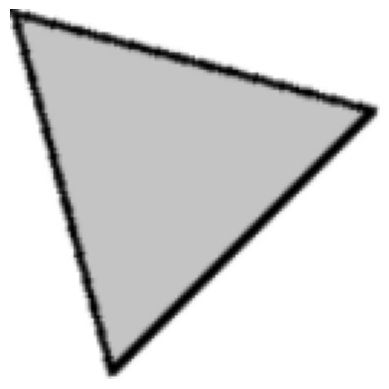

In [9]:
# sample = random.choice(matrices)
sample = matrices[23]

# collect all shapes as one batched tensor
all_shapes = torch.tensor(0)
for panel in sample:
    img = panel["img"]
    for box in panel["locs"]:
        shape = Resize((
            global_cfg.REPRESENTATION.TRAINING.patch_size,
            global_cfg.REPRESENTATION.TRAINING.patch_size
        ))(crop_img(img, box)).unsqueeze(0)
        all_shapes = shape if all_shapes.dim() == 0 else torch.cat((all_shapes, shape), dim=0)

# embed
all_shapes = all_shapes.to(device)
with torch.no_grad():
    mu, logvar = model.encode(all_shapes)
    z = sample_z(mu, logvar).cpu()

for dim in range(global_cfg.REPRESENTATION.MODEL.latent_dim):
    clustering = MeanShift().fit(z[:, dim].reshape(-1, 1)) # pyright: ignore[reportArgumentType]
    print(f"Found {len(np.unique(clustering.labels_))} clusters in dimension {dim}.")

    # plot distribution
    plt.figure(figsize=(10, 0.5))
    plt.scatter(z[:, dim], [1]*z.shape[0], c = clustering.labels_, cmap = "Set2")
    plt.axis('off')
    plt.show()

    # plot clusters
    for idx, count in zip((tmp := np.unique_counts(clustering.labels_)).values, tmp.counts):
        fig, axs = plt.subplots(1, count)
        relevant_shapes = [i for i, label in enumerate(clustering.labels_) if label == idx]
        assert len(relevant_shapes) == count

        for fig_idx, shape_idx in enumerate(relevant_shapes):
            img = all_shapes[shape_idx].cpu().permute(1, 2, 0).clip(0, 1)
            axs[fig_idx].imshow(img) if count > 1 else plt.imshow(img) # pyright: ignore[reportIndexIssue]
            axs[fig_idx].set_axis_off() if count > 1 else plt.axis('off') # pyright: ignore[reportIndexIssue]
        plt.show()
    